# Exploratory Data Analysis & Feature Engineering

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#cleaning">Data Cleaning</a></li>
<li><a href="#feature">Feature Engineering</a></li>
<li><a href="#export">Export Data</a></li>
</ul>

<a id='intro'></a>
## Introduction
This dataset consists of over 8.5M rows of consumer behavior data across an online cosmetics storefront. Every record contains a unique timestamp corresponding to an action the user took on the site; which includes viewing a product, adding a product to their cart, removing a product from the cart, and purchasing an item.  

The goal for this project is to predict if a customer will make <font color='red'>[their first?]</font> purchase. To achieve this, all of the features will need to be created to aggregate individual user actions leading up to their purchase.

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import pickle

import psycopg2 as pg
import pandas.io.sql as pd_sql

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# set plot style for visualizations
#plt.style.use('dark_background')
plt.style.use('ggplot')

In [3]:
# set up connection to postgres
connection_args = {
    'host': 'localhost',  
    'dbname': 'events',    
    'port': 5432          
}
connection = pg.connect(**connection_args)

In [4]:
# read in the dataset and label columns
query = "SELECT * FROM all_events;"
df = pd_sql.read_sql(query, connection)
print(df.shape)
df.head()

(8738120, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00,cart,5773203,1.487580e+18,None,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03,cart,5773353,1.487580e+18,None,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07,cart,5881589,2.151191e+18,None,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07,cart,5723490,1.487580e+18,None,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15,cart,5881449,1.487580e+18,None,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


The dataset contains 8.7M rows and 9 columns. The data represents individual actions taken by each user throughout each session.

<a id='cleaning'></a>
## Data Cleaning
<ol>
<li><a href="#cosmetics">Non-cosmetics categories</a></li>
<li><a href="#negative">Negatively priced items</a></li>
<li><a href="#remove">Removed from cart</a></li>
<li><a href="#first">One-time visitors</a></li>
</ol>

In [5]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8738120 entries, 0 to 8738119
Data columns (total 9 columns):
event_time       8738120 non-null datetime64[ns]
event_type       8738120 non-null object
product_id       8738120 non-null int64
category_id      8738120 non-null float64
category_code    143225 non-null object
brand            5092830 non-null object
price            8738120 non-null float64
user_id          8738120 non-null int64
user_session     8736670 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 600.0+ MB


There are quite a few null values in the `category_code` column.

In [6]:
df.category_code.value_counts()

appliances.environment.vacuum             59761
stationery.cartrige                       26722
apparel.glove                             18232
furniture.living_room.cabinet             13439
accessories.bag                           11681
furniture.bathroom.bath                    9857
appliances.personal.hair_cutter            1643
accessories.cosmetic_bag                   1248
appliances.environment.air_conditioner      332
furniture.living_room.chair                 308
sport.diving                                  2
Name: category_code, dtype: int64

<a id='cosmetics'></a>
### 1. Non-cosmetics categories

The non-null columns appear to be non-cosmetic. These are assumed to be erroneous data and will be removed from the dataset.

In [7]:
df = df[df.category_code.isnull()]
df.shape

(8594895, 9)

<a id='negative'></a>
### 2. Negatively priced items

Next let's look at the range in product pricing. Gauging propensity to purchase could potentially be pricing based, so it's good to get a sense of the pricing distribution

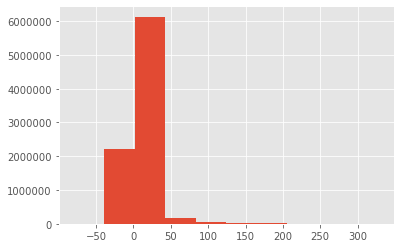

In [8]:
df.price.hist();

There seem to be some items that are priced negatively.

In [9]:
df[df.price < 0]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
112860,2019-10-01 19:10:56,purchase,5716857,1.487580e+18,None,None,-23.81,552507528,dcdd60c6-1a70-442d-bfb2-0252879054ad
198302,2019-10-02 08:30:03,purchase,5716855,1.487580e+18,None,None,-7.94,550375225,5ddec778-9464-4514-914d-be7b751b8e2c
436918,2019-10-03 17:37:04,purchase,5716859,1.487580e+18,None,None,-47.62,555414763,479149eb-1807-4178-8f6b-87c642350735
443204,2019-10-03 18:25:39,purchase,5670257,1.487580e+18,None,None,-15.87,556383221,4333d203-bc4d-4d0d-a6e1-0ea3a97a28c1
1295556,2019-10-09 14:49:14,purchase,5716855,1.487580e+18,None,None,-7.94,514562574,fed2aeb4-0c75-44f7-9ca8-1a8be8214779
1426186,2019-10-10 14:33:29,purchase,5716855,1.487580e+18,None,None,-7.94,558797258,a406cf28-f04b-4361-8e6a-c62d36045e07
1519246,2019-10-11 10:27:19,purchase,5716859,1.487580e+18,None,None,-47.62,543647038,85e11d74-6583-4eab-b50c-ff86dbb25d97
1783312,2019-10-13 16:46:01,purchase,5716857,1.487580e+18,None,None,-23.81,559820267,f178c995-f004-4040-b26d-b1cca0f9657d
1924072,2019-10-14 17:33:24,purchase,5716861,1.487580e+18,None,None,-79.37,541122983,b60f777d-afca-4299-8548-273b810d6130
2143763,2019-10-16 11:41:06,purchase,5716857,1.487580e+18,None,None,-23.81,461943726,beefa8fb-a3d1-48ca-97e9-9c95b05ee997


It looks like each of these events correspond to a customer purchase. These could potentially be returned items. With that in mind, line items with negative purchases will be removed from the dataset.

In [10]:
df = df[df.price > 0]
df.shape

(8577459, 9)

<a id='remove'></a>
### 3. Removed from cart

In [11]:
df.event_type.value_counts()

view                3832727
cart                2512700
remove_from_cart    1671299
purchase             560733
Name: event_type, dtype: int64

Next I will look at event types to see what behaviors will be incorporated into the model in order to predict a future purchase.

In [12]:
df.event_type.value_counts()

view                3832727
cart                2512700
remove_from_cart    1671299
purchase             560733
Name: event_type, dtype: int64

The different types of actions captured in the dataset include customer views of each product, adding items to cart, removing items from cart, and purchasing.  

Because my objective is to find customer purchases, I must handle the event types in a way that will not be duplicative. Each action taken by the customer is captured in the data, therefore all rows where a customer purchased a product will also have a row within that same session where the customer added the item to their cart.  

To account for this, counts of occurrences where a customer added an item to their cart should not include sessions where they made a purchase. With this in mind, removals from cart become duplicative and should be removed.

In [13]:
df = df[df.event_type.isin(['view', 'cart', 'purchase'])]
df.shape

(6906160, 9)

<a id='first'></a>
### 4. One-time visitors
One major source of variability in the data I may encounter when predicting future purchases is the presence of one-time visitors. One-time visitors may either buy or leave in their sole visit, which has the potential to throw off the model. Because I am looking to predict the first purchase a user will make, I will need more than one session per user to accurately predict future actions. As such, one-time visitors will be removed from the dataset.

In [14]:
# create dataframe of number of sessions per user, where the user logged more than one session
query = """
SELECT user_id,
       COUNT(user_session)
FROM all_events
GROUP BY 1
HAVING COUNT(user_session) > 1;
"""
one_visit = pd_sql.read_sql(query, connection)
one_visit

,user_id,count
0,1458813,31
1,4103071,8
2,5493470,10
3,8846226,47
4,9478445,4
...,...,...
397853,579963467,2
397854,579964807,3
397855,579964964,2
397856,579966747,18


In [15]:
# filter original dataframe to include only the user IDs found in query
df = df[df.user_id.isin(one_visit.user_id.values)]
df.shape

(6601004, 9)

### Data Cleaning Summary
1. Remove extraneous product categories (non-cosmetics products)
2. Remove negatively priced items
3. Remove rows with `remove_from_cart`
4. Filter out one-time users

<a id='feature'></a>
## Feature Engineering

### Create Target
The target I am aiming to predict from this dataset is if a customer will make a purchase. The first step is to create a column that turns the "purchase" event into a binary classifier. From there, I can begin engineering other features to predict the event.

In [16]:
# create target column with binary classifier
df['purchased'] = np.where(df['event_type'] == 'purchase', 1, 0)

This approach will use features that are "user-centric," meaning each line item will hold values for unique users. Each feature will contain roll-ups of that user's activity throughout the time period in which the data was captured.

In [17]:
# group the original dataframe by user
by_user = df.groupby('user_id', as_index=False).purchased.sum()

In [18]:
# create a column to hold the total number of purchases per user
# change the 'purchased' column to a binary classification
by_user['num_purchases'] = by_user['purchased']
by_user['purchased'] = (by_user['purchased'] >= 1).astype(int)
by_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391900 entries, 0 to 391899
Data columns (total 3 columns):
user_id          391900 non-null int64
purchased        391900 non-null int64
num_purchases    391900 non-null int64
dtypes: int64(3)
memory usage: 12.0 MB


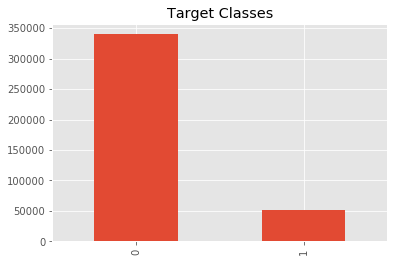

In [19]:
# visualize feature classes to assess if there is imbalance
by_user.purchased.value_counts().plot(kind='bar')
plt.title('Target Classes');

Whoa. The result set is highly skewed with more users that have not purchased, which is in line with what I'd expect for e-commerce data within this window. I will have to take this into account when testing classification methods by stratifying the prediction and over/undersampling.

### Recency, Frequency, Monetary Value
Recency, frequency, and monetary value, commonly known as RFM, is a widely used metric in marketing analytics. This metric aims to group individual users into user segments, or cohorts, based on three factors:
1. **Recency** - The last time the user made a purchase in the store. Since I am aiming to gauge future purchases based on behavior, I am adjusting this metric to reflect the last time the user made an action on the site. This value is represented as the number of days between the current date and the date of the last user action.
2. **Frequency** - How many times the user made a purchase in a given window. Again, I will adjust this metric to include the number of actions taken rather than the number of purchases to better predict future purchases based on all behavior. 
3. **Monetary value** - The total dollar amount of all purchases made by the user. Similar to the other components, the typical RFM calculation will not work here, as we do not know whether the customer has made a purchase or not. To account for this, this value will measure the total value of products the customer has interacted with.

In [20]:
# run sql query that calculates RFM scores and create dataframe
query = """
WITH rfm_raw AS (
    SELECT user_id,
           EXTRACT(DAY FROM CURRENT_DATE - MAX(event_time)) AS recency,
           COUNT(DISTINCT user_session) AS frequency,
           SUM(CASE WHEN event_type != 'purchase' THEN price END) AS monetary_value
    FROM all_events
    GROUP BY 1
),
rfm_scores AS (
    SELECT rfm_raw.user_id,
           NTILE(5) OVER(ORDER BY recency DESC) AS r,
           NTILE(5) OVER(ORDER BY frequency DESC) AS f,
           NTILE(5) OVER(ORDER BY monetary_value DESC) AS m
    FROM all_events
    JOIN rfm_raw
    ON all_events.user_id = rfm_raw.user_id
)

SELECT DISTINCT user_id,
       CONCAT(r, f, m) AS rfm_score
FROM rfm_scores;
"""
rfm = pd_sql.read_sql(query, connection)

In [21]:
rfm.head()

,user_id,rfm_score
0,1120748,255
1,1458813,334
2,4103071,155
3,5493470,255
4,6217356,355


### Actions per user
Calculate the number of each unique action per user; purchases, product views, adds to cart, and removals from cart. These will all be separate features. Total number of purchases was already created when grouping by user, so this step will focus on creating features to quantify the other types of action.

In [22]:
query = """
SELECT user_id,
       SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS num_purchases,
       SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) AS num_views,
       SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS adds_to_cart,
       SUM(CASE WHEN event_type = 'remove_from_cart' THEN 1 ELSE 0 END) AS removals_from_cart
FROM all_events
GROUP BY 1;
"""
actions = pd_sql.read_sql(query, connection)

In [23]:
actions.head()

,user_id,num_purchases,num_views,adds_to_cart,removals_from_cart
0,1120748,0,1,0,0
1,1458813,0,31,0,0
2,4103071,0,7,1,0
3,5493470,0,5,5,0
4,6217356,0,0,1,0


<a id='export'></a>
## Export Data
Merge dataframes created with new features to the original, grouped dataframe. Export the resulting dataframe as the dataset to run classification models.

In [24]:
# merge rfm scores onto grouped dataframe
users = by_user.merge(rfm, on='user_id')

In [25]:
# drop extra 'num_purchases' column from actions dataframe
actions = actions.drop('num_purchases', axis=1)

In [26]:
# merge user actions data
users = users.merge(actions, on='user_id')

In [27]:
users.head()

,user_id,purchased,num_purchases,rfm_score,num_views,adds_to_cart,removals_from_cart
0,1458813,0,0,334,31,0,0
1,4103071,0,0,155,7,1,0
2,5493470,0,0,255,5,5,0
3,8846226,0,0,144,7,24,16
4,9478445,0,0,235,4,0,0


<font color='red'>Drop other num_purchases column for model, but may want to include this again at some point...?</font>

In [28]:
users = users.drop('num_purchases', axis=1)

In [29]:
# export dataframe to pickle file to easily import in modeling notebook
with open('users.pickle', 'wb') as outfile:
    pickle.dump(users, outfile)

<font color='red'><h1>Additional features</h1></font>

#### Add to cart rate
Calculate the number of each unique action per user; purchases, product views, adds to cart, and removals from cart. These will all be separate features. Total number of purchases was already created when grouping by user, so this step will focus on creating features to quantify the other types of action.

In [30]:
users_copy = users.copy()

In [31]:
users_copy

,user_id,purchased,rfm_score,num_views,adds_to_cart,removals_from_cart
0,1458813,0,334,31,0,0
1,4103071,0,155,7,1,0
2,5493470,0,255,5,5,0
3,8846226,0,144,7,24,16
4,9478445,0,235,4,0,0
...,...,...,...,...,...,...
392049,579963467,0,555,2,0,0
392050,579964807,0,555,3,0,0
392051,579964964,0,555,2,0,0
392052,579966747,0,555,4,11,3
